# Mall Customer Segmentation
Using data extracted from customer shopping data at a mall, assess features into clusters using a Gaussian Mixture Model.

## Data Preprocessing

In [11]:
import pandas as pd

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [13]:
# Check for missing values
print(df.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [14]:
# Drop any duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(200, 5)
(200, 5)


In [15]:
# Encode gender column
df['Gender'] = df['Gender'].astype('category').cat.codes
# Male = 1, Female = 0
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [17]:
# Dropping the ID column as that has little impact on patterns
df.drop(['CustomerID'], axis=1, inplace=True)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [18]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

### Baseline Gaussian Mixture Model
To show the effectiveness of Advanced Clustering techniques, I will first train a baseline Gaussian Mixture Model to compare to my final model.

In [30]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

baseline_gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
baseline_gmm.fit(X_scaled)
baseline_preds = baseline_gmm.predict(X_scaled)

# Get evaluation metrics
baseline_ll = baseline_gmm.score(X_scaled)
baseline_aic = baseline_gmm.aic(X_scaled)
baseline_bic = baseline_gmm.bic(X_scaled)

In [34]:
# Saving baseline labels as a column
df_compare = df.copy()
df_compare['Baseline_Cluster'] = baseline_preds
df_compare.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Baseline_Cluster
0,1,19,15,39,1
1,1,21,15,81,1
2,0,20,16,6,1
3,0,23,16,77,0
4,0,31,17,40,1


## Building the Gaussian Mixture Model

Scikit-Learn features a Gaussian Mixture Model algorithm. In this step, I will be building the model to cluster the data.

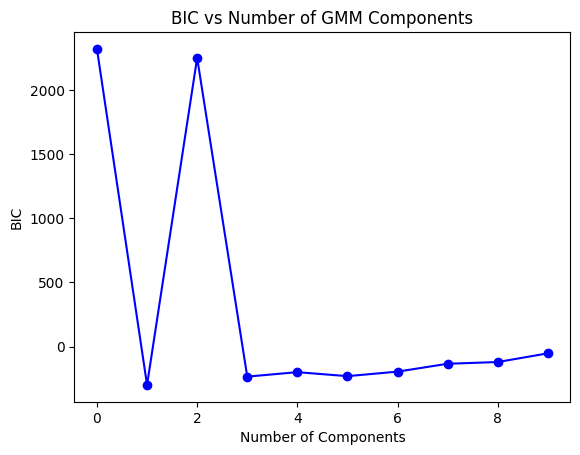

In [ ]:
# Choose the number of components using Bayesian Information Criterion
# Comparable to using the elbow method in K-Means
bic = []

for n in range(1,11):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

plt.plot(bic, 'bo-', label='BIC')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC vs Number of GMM Components")
plt.show()

In [43]:
# Using 5 components to train the final Gaussian Mixture Model
model = GaussianMixture(n_components=5, covariance_type='full', 
                        reg_covar=0.0001, n_init=5, random_state=42)
model.fit(X_scaled)
labels = model.predict(X_scaled)
cluster_probas = model.predict_proba(X_scaled)

# Get evaluation metrics
model_ll = model.score(X_scaled)
model_aic = model.aic(X_scaled)
model_bic = model.bic(X_scaled)

df_compare['Model_Cluster'] = labels
df_compare

,Gender,Age,Annual Income (k$),Spending Score (1-100),Baseline_Cluster,Model_Cluster
0,1,19,15,39,1,3
1,1,21,15,81,1,3
2,0,20,16,6,1,4
3,0,23,16,77,0,1
4,0,31,17,40,1,4
...,...,...,...,...,...,...
195,0,35,120,79,1,2
196,0,45,126,28,1,4
197,1,32,126,74,1,3
198,1,32,137,18,1,0


### Model Comparison
Use PCA to plot the identified clusters from both models to compare the clustering ability.

In [44]:
# Display evaluation metrics
results = [{
    "Model": "Baseline GMM",
    "Components": 2,
    "Covariance": "Spherical",
    "Log-Likelihood": baseline_ll,
    "AIC": baseline_aic,
    "BIC": baseline_bic},
    {"Model": "Model GMM",
    "Components": 5,
    "Covariance": "Full",
    "Log-Likelihood": model_ll,
    "AIC": model_aic,
    "BIC": model_bic}]

df_results = pd.DataFrame(results)
df_results

,Model,Components,Covariance,Log-Likelihood,AIC,BIC
0,Baseline GMM,2,Spherical,-5.604029,2263.611752,2299.893243
1,Model GMM,5,Full,-0.659716,411.886448,655.961933


## Understanding Evaluation Metrics
- Log-Likelihood: a higher value indicates better clustering
- AIC: a lower value indicates better clustering
- BIC: a lower value indicates better clustering

Using these metrics, a significant improvement to clustering is observed.

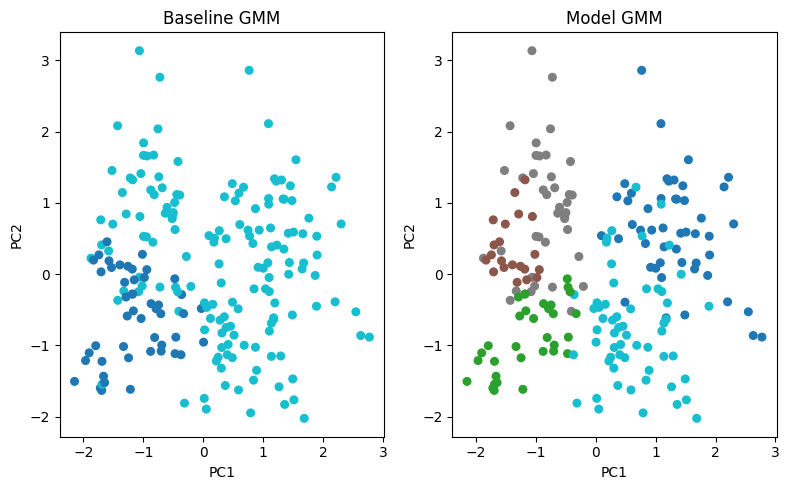

In [45]:
# Visual comparison of clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
# Baseline
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=baseline_preds,
    cmap="tab10", s=30)
ax1.set_title("Baseline GMM")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# GMM
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=labels,
    cmap="tab10", s=30)
ax2.set_title("Model GMM")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.show()


## Cluster Analysis
To validate model performance, I will analyze the clusters made to ensure that they are sensible, logical, and usable.

In [46]:
# Get cluster sizes
df_compare['Model_Cluster'].value_counts().sort_index()

Model_Cluster
0    49
1    33
2    21
3    39
4    58
Name: count, dtype: int64

In [47]:
# Examing cluster centroids
pd.DataFrame(model.means_, columns=df.columns)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,0.742343,0.065363,-0.796130
1,-0.886405,-0.967517,-0.638214,0.432139
2,-0.886405,-0.477694,0.966164,1.216977
3,1.128152,-0.772135,0.061487,0.846262
4,-0.886405,0.575350,-0.100565,-0.560339


In [50]:
# Analyze prediction confidence
max_probs = cluster_probas.max(axis=1)
pd.Series(max_probs).describe()

count    200.000000
mean       0.981629
std        0.070013
min        0.504017
25%        0.997215
50%        0.999951
75%        1.000000
max        1.000000
dtype: float64

With these metrics I draw the following conclusions:
- Clusters are balanced and even, where samples are generally evenly distributed across all clusters.
- Cluster centroids are unique with a clear difference across clusters. Different combinations of features dictate the cluster centroids.
- The model is very confident in its cluster groupings, having near 100% confidence on its predictions, with its lowest confidence being 50% confidence; however, this may be an outlier considering the standard deviation of 7% from the mean of 98% confidence.

In [54]:
# Grouping clusters to show clusters and their features
df_compare.drop('Baseline_Cluster', axis=1, inplace=True)
df_compare.groupby('Model_Cluster').mean()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Model_Cluster,,,,
0,1.0,49.204082,62.244898,29.734694
1,0.0,25.545455,44.484848,60.696970
2,0.0,32.190476,86.047619,81.666667
3,1.0,28.000000,62.205128,72.102564
4,0.0,47.379310,57.948276,35.396552


### Identified cluster patterns
- There are 2 clusters for men (0 and 3) and 3 clusters for women (1, 2, 4).
- All clusters represent the different age groups between men and women.

### Cluster Insights
- Young men typically make the same income as older men but spend much more at the mall.
- On average, men spend less money than women.
- Middle aged women (around 32) spend the most at the mall, and consequently have the highest annual income.
- Older women (around 47) spend the least at the mall.

### Conclusion
The clusters are able to make unique and specific clusters that can yield logical insights on customer shopping trends. Based on the clusters made by the GMM, the mall can create a marketing strategy that targets middle aged women, since that demographic spends the most at the mall. Moreover, the mall may also choose to invest in products/stores that cater to young men, as they spend more money compared to older men. This may increase overall sales across multiple high-value demographics.